In [1]:
# Run this if in COLAB
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip
    
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week5_explore/bayes.py
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week5_explore/action_rewards.npy
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week5_explore/all_states.npy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     | 13.4 MB 126 kB/s    \ 7.6 MB 119 kB/s
  Created wheel for Theano: filename=Theano-1.0.5+unknown-py3-none-any.whl size=2667284 sha256=6ff1a9145fd03e6a021eb2d54fb32b01643c4ec6d127bd66cdce94d717fc9aa2
  Stored in directory: /tmp/pip-ephem-wheel-cache-tozs2oo_/wheels/32/8b/4c/8a30b84821c18fa2ad9e5393670c72972765d4900c708112b8
Successfully built Theano
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     - 231 kB 51 kB/ssB/s
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-py3-none-any.whl size=122798 sha256=c4b9a32670655ef8bc09a912acfcbd29345855564473cfdc73ad5d5a86fd12c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-e07qlsis/wheels/a1/a7/f1/9866212641380e81b2b2a0f6ed6e609b7152ab9f7c893c22ee
Successfully built Lasagne


In [12]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas

from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
# 某些函数的确认
#np.random.random(5)
#np.cumsum?
# 按每移动一个元素累计之前值
np.random.choice?

## Contents
* [1. Bernoulli Bandit](#Part-1.-Bernoulli-Bandit)
    * [Bonus 1.1. Gittins index (5 points)](#Bonus-1.1.-Gittins-index-%285-points%29.)
    * [HW 1.1. Nonstationary Bernoulli bandit](#HW-1.1.-Nonstationary-Bernoulli-bandit)
* [2. Contextual bandit](#Part-2.-Contextual-bandit)
    * [2.1 Bulding a BNN agent](#2.1-Bulding-a-BNN-agent)
    * [2.2 Training the agent](#2.2-Training-the-agent)
    * [HW 2.1 Better exploration](#HW-2.1-Better-exploration)
* [3. Exploration in MDP](#Part-3.-Exploration-in-MDP)
    * [Bonus 3.1 Posterior sampling RL (3 points)](#Bonus-3.1-Posterior-sampling-RL-%283-points%29)
    * [Bonus 3.2 Bootstrapped DQN (10 points)](#Bonus-3.2-Bootstrapped-DQN-%2810-points%29)


## Part 1. Bernoulli Bandit

We are going to implement several exploration strategies for simplest problem - bernoulli bandit.

The bandit has $K$ actions. Action produce 1.0 reward $r$ with probability $0 \le \theta_k \le 1$ which is unknown to agent, but fixed over time. Agent's objective is to minimize regret over fixed number $T$ of action selections:

$$\rho = T\theta^* - \sum_{t=1}^T r_t$$

Where $\theta^* = \max_k\{\theta_k\}$

**Real-world analogy:**

Clinical trials - we have $K$ pills and $T$ ill patient. After taking pill, patient is cured with probability $\theta_k$. Task is to find most efficient pill.

A research on clinical trials - https://arxiv.org/pdf/1507.08025.pdf

In [13]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        # 每个动作产收益的随机概率0-1之间。
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        # 发出动作产生收益。
        if np.random.random() > self._probs[action]:
            return 0.0
        return 1.0

    def optimal_reward(self):
        """ Used for regret calculation
        """
        # 找出产生最大收益的概率值是什么0-1之间？
        return np.max(self._probs)

    def step(self):
        """ Used in nonstationary version
        """
        pass

    def reset(self):
        """ Used in nonstationary version
        """

In [14]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions) # 零化每个动作收益成功标记。
        self._failures = np.zeros(n_actions) # 零化每个动作收益的失败标记。
        self._total_pulls = 0 # 记录总实施动作的次数

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        # 接口，获得最好的行动a。
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        # 更新收益成功、失败的数量、总行动个数。
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        # 给继承本代理的子类一个名字。
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    # 随机产生动作的代理子类。
    def get_action(self):
        return np.random.randint(0, len(self._successes))

### Epsilon-greedy agent

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

Implement the algorithm above in the cell below:

In [24]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon

    def get_action(self):
        # YOUR CODE HERE
        # 计算最样本中最好的收益的行动是谁？
        alpha = self._successes
        bata = self._failures
        theata_k = alpha / (alpha + bata)
        print(theata_k)
        max_a = np.argmax(theata_k)
        # 实施贪婪选择。
        if np.random.random() > self._epsilon:
            a = int(max_a) 
        else:
            a = np.random.choice(a = len(self._successes), size = 1)
        return a
        
    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

### UCB Agent
Epsilon-greedy strategy heve no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents otimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; **end for** 
 $x_t \leftarrow argmax_{k}w$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [91]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        # YOUR CODE HERE

### Thompson sampling

UCB1 algorithm does not take into account actual distribution of rewards. If we know the distribution - we can do much better by using Thompson sampling:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**
 

More on Thompson Sampling:
https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [95]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        # YOUR CODE HERE

In [25]:
def plot_regret(env, agents, n_steps=5000, n_trials=50):
    # 每个代理给5千个硬币玩玩。先初始化得分为每个币的（获益差距累计）为0。
    scores = {
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    }
    # 给玩五十局。
    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)
        # 开始每个硬币投注。
        for i in range(n_steps):
            optimal_reward = env.optimal_reward()
            # 不同代理同时玩老虎机但使用同一老虎机。
            for agent in agents:
                # 取得最适当的行动。
                action = agent.get_action()
                # 看看行动收益。
                reward = env.pull(action)
                # 更新统计结果。
                agent.update(action, reward)
                # 更新每个硬币的投币后的（实际最好与代理最好）的差距累加增量
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    plt.figure(figsize=(17, 8))
    for agent in agents:
        # 累计每个投币时刻的暂时总获益平均值。
        plt.plot(np.cumsum(scores[agent.name]) / n_trials)

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


[nan nan nan nan nan]
[ 0. nan nan nan nan]
[ 0.  0. nan nan nan]
[ 0.  0.  0. nan nan]
[ 0.  0.  0.  0. nan]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0.333 0.    0.    0.    0.   ]
[0.25 0.   0.   0.   0.  ]
[0.2 0.  0.  0.  0. ]
[0.167 0.    0.    0.    0.   ]
[0.143 0.    0.    0.    0.   ]
[0.125 0.    0.    0.    0.   ]
[0.111 0.    0.    0.    0.   ]
[0.1 0.  0.  0.  0. ]
[0.182 0.    0.    0.    0.   ]
[0.25 0.   0.   0.   0.  ]
[0.231 0.    0.    0.    0.   ]
[0.214 0.    0.    0.    0.   ]
[0.2 0.  0.  0.  0. ]
[0.188 0.    0.    0.    0.   ]
[0.235 0.    0.    0.    0.   ]
[0.222 0.    0.    0.    0.   ]
[0.211 0.    0.    0.    0.   ]
[0.2 0.  0.  0.  0. ]
[0.19 0.   0.   0.   0.  ]
[0.182 0.    0.    0.    0.   ]
[0.174 0.    0.    0.    0.   ]
[0.167 0.    0.    0.    0.   ]
[0.16 0.   0.   0.   0.  ]
[0.154 0.    0.    0.    0.   ]
[0.148 0.    0.    0.    0.   ]
[0.143 0.    0.    0.    0.   ]
[0.138 0.    0.    0.    0.   ]
[0.133 0.    0.    0.    0.   ]
[0.129 0.    0.    0

[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.403 0.4   0.   ]
[0.205 0.333 0.403 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.403 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.403 0.4   0.   ]
[0.205 0.333 0.403 0.4   0.   ]
[0.205 0.333 0.403 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.401 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.403 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0.333 0.401 0.4   0.   ]
[0.205 0.333 0.401 0.4   0.   ]
[0.205 0.333 0.401 0.4   0.   ]
[0.205 0.333 0.401 0.4   0.   ]
[0.205 0.333 0.401 0.4   0.   ]
[0.205 0.333 0.4   0.4   0.   ]
[0.205 0.333 0.4   0.4   0.   ]
[0.205 0.333 0.401 0.4   0.   ]
[0.205 0.333 0.401 0.4   0.   ]
[0.205 0.333 0.402 0.4   0.   ]
[0.205 0

[0.203 0.25  0.394 0.469 0.143]
[0.203 0.25  0.394 0.472 0.143]
[0.203 0.25  0.394 0.474 0.143]
[0.203 0.25  0.394 0.472 0.143]
[0.203 0.25  0.394 0.469 0.143]
[0.203 0.25  0.394 0.472 0.143]
[0.203 0.25  0.394 0.475 0.143]
[0.203 0.25  0.394 0.472 0.143]
[0.203 0.25  0.394 0.475 0.143]
[0.203 0.25  0.394 0.473 0.143]
[0.203 0.25  0.394 0.47  0.143]
[0.203 0.25  0.394 0.468 0.143]
[0.203 0.25  0.394 0.471 0.143]
[0.203 0.25  0.394 0.468 0.143]
[0.203 0.25  0.394 0.471 0.143]
[0.203 0.25  0.394 0.469 0.143]
[0.203 0.25  0.394 0.471 0.143]
[0.203 0.25  0.394 0.469 0.143]
[0.203 0.25  0.394 0.471 0.143]
[0.203 0.25  0.394 0.469 0.143]
[0.203 0.25  0.394 0.472 0.143]
[0.203 0.25  0.394 0.469 0.143]
[0.203 0.25  0.394 0.472 0.143]
[0.203 0.25  0.394 0.47  0.143]
[0.203 0.25  0.394 0.472 0.143]
[0.203 0.25  0.394 0.475 0.143]
[0.203 0.25  0.394 0.472 0.143]
[0.203 0.25  0.394 0.475 0.143]
[0.203 0.25  0.394 0.477 0.143]
[0.203 0.25  0.394 0.48  0.143]
[0.203 0.25  0.394 0.482 0.143]
[0.203 0

[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.47  0.111]
[0.2   0.167 0.394 0.47  0.111]
[0.2   0.167 0.394 0.47  0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.47  0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.47  0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.472 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.472 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.472 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.471 0.111]
[0.2   0.167 0.394 0.47  0.111]
[0.2   0.167 0.394 0.47  0.111]
[0.2   0

[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.467 0.2  ]
[0.199 0.133 0.394 0.467 0.2  ]
[0.199 0.133 0.394 0.467 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.468 0.2  ]
[0.199 0.133 0.394 0.467 0.2  ]
[0.199 0

[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.471 0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0.235 0.393 0.47  0.188]
[0.199 0

[0.196 0.25  0.393 0.469 0.19 ]
[0.196 0.25  0.393 0.469 0.19 ]
[0.196 0.25  0.393 0.469 0.19 ]
[0.196 0.25  0.393 0.469 0.19 ]
[0.196 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.469 0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0.25  0.393 0.47  0.19 ]
[0.195 0

[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0.273 0.394 0.47  0.16 ]
[0.197 0

[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.469 0.154]
[0.196 0.269 0.394 0.469 0.154]
[0.196 0.269 0.394 0.469 0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0.269 0.394 0.47  0.154]
[0.196 0

[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0.296 0.394 0.469 0.143]
[0.194 0

[0.    0.    0.42  0.333 0.   ]
[0.    0.    0.421 0.333 0.   ]
[0.    0.    0.423 0.333 0.   ]
[0.    0.    0.424 0.333 0.   ]
[0.    0.    0.423 0.333 0.   ]
[0.    0.    0.422 0.333 0.   ]
[0.    0.    0.424 0.333 0.   ]
[0.    0.    0.423 0.333 0.   ]
[0.    0.    0.422 0.333 0.   ]
[0.    0.    0.423 0.333 0.   ]
[0.    0.    0.422 0.333 0.   ]
[0.    0.    0.421 0.333 0.   ]
[0.    0.    0.421 0.333 0.   ]
[0.    0.    0.422 0.333 0.   ]
[0.    0.    0.421 0.333 0.   ]
[0.    0.    0.423 0.333 0.   ]
[0.    0.    0.422 0.333 0.   ]
[0.    0.    0.423 0.333 0.   ]
[0.    0.    0.424 0.333 0.   ]
[0.    0.    0.423 0.333 0.   ]
[0.    0.    0.425 0.333 0.   ]
[0.    0.    0.424 0.333 0.   ]
[0.    0.    0.423 0.333 0.   ]
[0.    0.    0.422 0.333 0.   ]
[0.    0.    0.421 0.333 0.   ]
[0.    0.    0.422 0.333 0.   ]
[0.    0.    0.424 0.333 0.   ]
[0.    0.    0.425 0.333 0.   ]
[0.    0.    0.424 0.333 0.   ]
[0.    0.    0.425 0.333 0.   ]
[0.    0.    0.424 0.333 0.   ]
[0.    0

[0.2   0.    0.394 0.333 0.   ]
[0.2   0.    0.393 0.333 0.   ]
[0.2   0.    0.393 0.333 0.   ]
[0.2   0.    0.393 0.333 0.   ]
[0.2   0.    0.393 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0.    0.393 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0.    0.393 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0.    0.391 0.333 0.   ]
[0.2   0.    0.391 0.333 0.   ]
[0.2   0.    0.391 0.333 0.   ]
[0.2   0.    0.391 0.333 0.   ]
[0.2   0.    0.391 0.333 0.   ]
[0.2   0.    0.391 0.333 0.   ]
[0.2   0.    0.391 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0.    0.393 0.333 0.   ]
[0.2   0.    0.393 0.333 0.   ]
[0.2   0.    0.393 0.333 0.   ]
[0.2   0.    0.393 0.333 0.   ]
[0.2   0.    0.392 0.333 0.   ]
[0.2   0

[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.391 0.333 0.   ]
[0.25  0.    0.391 0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.391 0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.391 0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0.    0.39  0.333 0.   ]
[0.25  0

[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.25  0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0.    0.39  0.364 0.077]
[0.222 0

[0.2   0.1   0.394 0.364 0.067]
[0.2   0.1   0.394 0.364 0.067]
[0.2   0.1   0.394 0.364 0.067]
[0.2   0.1   0.394 0.364 0.067]
[0.2   0.1   0.394 0.364 0.067]
[0.2   0.1   0.394 0.364 0.067]
[0.2   0.1   0.394 0.364 0.067]
[0.2   0.1   0.394 0.364 0.067]
[0.2   0.1   0.394 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0.1   0.393 0.364 0.067]
[0.2   0

[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.395 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.395 0.333 0.067]
[0.154 0.091 0.395 0.333 0.067]
[0.154 0.091 0.395 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.394 0.333 0.067]
[0.154 0.091 0.395 0.333 0.067]
[0.154 0.091 0.395 0.333 0.067]
[0.154 0.091 0.395 0.333 0.067]
[0.154 0.091 0.395 0.333 0.067]
[0.154 0.091 0.395 0.333 0.067]
[0.154 0.091 0.395 0.333 0.067]
[0.154 0

[0.235 0.083 0.389 0.294 0.067]
[0.235 0.083 0.389 0.294 0.067]
[0.235 0.083 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0.077 0.389 0.294 0.067]
[0.235 0

[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.385 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0.133 0.384 0.286 0.167]
[0.222 0

[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.15 ]
[0.222 0.167 0.382 0.286 0.143]
[0.222 0.167 0.382 0.286 0.143]
[0.222 0.167 0.382 0.286 0.143]
[0.222 0.167 0.382 0.286 0.143]
[0.222 0.167 0.382 0.286 0.143]
[0.222 0.167 0.382 0.286 0.143]
[0.222 0.167 0.382 0.286 0.143]
[0.222 0.167 0.382 0.286 0.143]
[0.222 0

[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0.158 0.381 0.348 0.136]
[0.211 0

[0.    0.333 0.333 0.471 0.   ]
[0.    0.333 0.333 0.472 0.   ]
[0.    0.333 0.333 0.471 0.   ]
[0.    0.333 0.333 0.47  0.   ]
[0.    0.333 0.333 0.47  0.   ]
[0.    0.333 0.333 0.469 0.   ]
[0.    0.333 0.333 0.468 0.   ]
[0.    0.333 0.333 0.467 0.   ]
[0.    0.333 0.333 0.467 0.   ]
[0.    0.333 0.333 0.466 0.   ]
[0.    0.333 0.333 0.465 0.   ]
[0.    0.333 0.333 0.465 0.   ]
[0.    0.333 0.333 0.465 0.   ]
[0.    0.333 0.333 0.466 0.   ]
[0.    0.333 0.333 0.467 0.   ]
[0.    0.333 0.333 0.468 0.   ]
[0.    0.333 0.333 0.469 0.   ]
[0.    0.333 0.333 0.468 0.   ]
[0.    0.333 0.333 0.467 0.   ]
[0.    0.333 0.333 0.467 0.   ]
[0.    0.333 0.333 0.466 0.   ]
[0.    0.333 0.333 0.467 0.   ]
[0.    0.333 0.333 0.466 0.   ]
[0.    0.333 0.333 0.467 0.   ]
[0.    0.333 0.333 0.466 0.   ]
[0.    0.333 0.333 0.467 0.   ]
[0.    0.333 0.333 0.466 0.   ]
[0.    0.333 0.333 0.465 0.   ]
[0.    0.333 0.333 0.466 0.   ]
[0.    0.333 0.333 0.466 0.   ]
[0.    0.333 0.333 0.465 0.   ]
[0.    0

[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.467 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.467 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.467 0.   ]
[0.    0.429 0.333 0.467 0.   ]
[0.    0.429 0.333 0.467 0.   ]
[0.    0.429 0.333 0.467 0.   ]
[0.    0.429 0.333 0.467 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.467 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0.429 0.333 0.468 0.   ]
[0.    0

[0.    0.417 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.463 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.463 0.167]
[0.    0.385 0.375 0.462 0.167]
[0.    0.385 0.375 0.463 0.167]
[0.    0.385 0.375 0.463 0.167]
[0.    0.385 0.375 0.463 0.167]
[0.    0.385 0.375 0.463 0.167]
[0.    0

[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.46  0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.46  0.167]
[0.143 0.357 0.273 0.46  0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0.357 0.273 0.461 0.167]
[0.143 0

[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.465 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.111 0.353 0.308 0.465 0.111]
[0.111 0.353 0.308 0.465 0.111]
[0.111 0.353 0.308 0.465 0.111]
[0.111 0.353 0.308 0.464 0.111]
[0.1   0.353 0.308 0.464 0.111]
[0.1   0.353 0.308 0.465 0.111]
[0.1   0.353 0.308 0.464 0.111]
[0.1   0.353 0.308 0.465 0.111]
[0.1   0.353 0.308 0.465 0.111]
[0.1   0.353 0.308 0.464 0.111]
[0.1   0.353 0.308 0.465 0.111]
[0.1   0.353 0.308 0.465 0.111]
[0.1   0.353 0.308 0.465 0.111]
[0.1   0.353 0.308 0.464 0.111]
[0.1   0.353 0.308 0.464 0.111]
[0.1   0.353 0.308 0.464 0.111]
[0.1   0.353 0.308 0.464 0.111]
[0.1   0

[0.1   0.368 0.308 0.46  0.083]
[0.1   0.368 0.308 0.46  0.083]
[0.1   0.368 0.308 0.46  0.083]
[0.1   0.368 0.308 0.46  0.083]
[0.1   0.368 0.308 0.46  0.083]
[0.1   0.368 0.308 0.46  0.083]
[0.1   0.368 0.308 0.46  0.083]
[0.1   0.368 0.308 0.46  0.083]
[0.1   0.368 0.308 0.461 0.083]
[0.1   0.368 0.308 0.461 0.083]
[0.1   0.368 0.308 0.461 0.083]
[0.1   0.368 0.308 0.461 0.083]
[0.1   0.368 0.308 0.461 0.083]
[0.1   0.368 0.308 0.461 0.083]
[0.1   0.368 0.308 0.461 0.083]
[0.1   0.368 0.308 0.461 0.083]
[0.1   0.368 0.308 0.46  0.083]
[0.1   0.368 0.308 0.46  0.077]
[0.1   0.368 0.308 0.46  0.077]
[0.1   0.368 0.308 0.46  0.077]
[0.1   0.368 0.308 0.46  0.077]
[0.1   0.368 0.308 0.46  0.077]
[0.1   0.368 0.308 0.46  0.077]
[0.1   0.368 0.308 0.46  0.077]
[0.1   0.368 0.308 0.46  0.077]
[0.1   0.368 0.308 0.46  0.077]
[0.1   0.368 0.308 0.461 0.077]
[0.1   0.368 0.308 0.461 0.077]
[0.1   0.368 0.308 0.461 0.077]
[0.1   0.368 0.308 0.461 0.077]
[0.1   0.368 0.308 0.461 0.077]
[0.1   0

[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.267 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0.391 0.312 0.461 0.077]
[0.154 0

[0.267 0.417 0.312 0.463 0.059]
[0.267 0.417 0.312 0.463 0.059]
[0.267 0.417 0.312 0.463 0.059]
[0.267 0.417 0.312 0.463 0.059]
[0.267 0.417 0.312 0.463 0.059]
[0.267 0.417 0.312 0.463 0.059]
[0.267 0.417 0.312 0.463 0.059]
[0.267 0.417 0.312 0.463 0.059]
[0.267 0.417 0.312 0.463 0.059]
[0.267 0.417 0.312 0.463 0.059]
[0.267 0.417 0.312 0.463 0.059]
[0.267 0.417 0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0.4   0.312 0.463 0.059]
[0.267 0

[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.463 0.053]
[0.25  0.429 0.333 0.463 0.053]
[0.25  0.429 0.333 0.463 0.053]
[0.25  0.429 0.333 0.463 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.463 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0.429 0.333 0.462 0.053]
[0.25  0

[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0.4   0.333 0.464 0.05 ]
[0.25  0

[0.    0.258 0.    0.458 0.333]
[0.    0.258 0.    0.457 0.333]
[0.    0.258 0.    0.458 0.333]
[0.    0.258 0.    0.459 0.333]
[0.    0.258 0.    0.458 0.333]
[0.    0.258 0.    0.457 0.333]
[0.    0.258 0.    0.458 0.333]
[0.    0.258 0.    0.459 0.333]
[0.    0.258 0.    0.46  0.333]
[0.    0.258 0.    0.461 0.333]
[0.    0.258 0.    0.46  0.333]
[0.    0.258 0.    0.461 0.333]
[0.    0.258 0.    0.462 0.333]
[0.    0.258 0.    0.463 0.333]
[0.    0.258 0.    0.462 0.333]
[0.    0.258 0.    0.461 0.333]
[0.    0.258 0.    0.461 0.333]
[0.    0.258 0.    0.46  0.333]
[0.    0.258 0.    0.459 0.333]
[0.    0.258 0.    0.46  0.333]
[0.    0.258 0.    0.459 0.333]
[0.    0.258 0.    0.46  0.333]
[0.    0.258 0.    0.461 0.333]
[0.    0.258 0.    0.462 0.333]
[0.    0.258 0.    0.463 0.333]
[0.    0.258 0.    0.464 0.333]
[0.    0.258 0.    0.463 0.333]
[0.    0.258 0.    0.464 0.333]
[0.    0.258 0.    0.465 0.333]
[0.    0.258 0.    0.464 0.333]
[0.    0.258 0.    0.465 0.333]
[0.    0

[0.    0.257 0.333 0.446 0.4  ]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.445 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.447 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.447 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.447 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.447 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.447 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.445 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0.257 0.333 0.446 0.333]
[0.    0

[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.45  0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0.26  0.333 0.451 0.333]
[0.2   0

[0.3   0.261 0.286 0.448 0.286]
[0.3   0.261 0.286 0.448 0.286]
[0.3   0.261 0.286 0.448 0.286]
[0.3   0.261 0.286 0.448 0.286]
[0.3   0.261 0.286 0.448 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.448 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.449 0.286]
[0.3   0.261 0.286 0.45  0.286]
[0.3   0.261 0.286 0.45  0.286]
[0.3   0.261 0.286 0.45  0.286]
[0.3   0.261 0.286 0.45  0.286]
[0.3   0.261 0.286 0.45  0.286]
[0.3   0

[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.273 0.454 0.222]
[0.231 0.265 0.333 0.454 0.222]
[0.231 0.265 0.333 0.455 0.222]
[0.231 0.265 0.333 0.454 0.222]
[0.231 0.265 0.333 0.455 0.222]
[0.231 0.265 0.333 0.455 0.222]
[0.231 0.265 0.333 0.455 0.222]
[0.231 0.265 0.333 0.455 0.222]
[0.231 0.265 0.333 0.455 0.222]
[0.231 0.265 0.333 0.455 0.222]
[0.231 0

[0.2   0.264 0.385 0.455 0.2  ]
[0.2   0.264 0.385 0.455 0.2  ]
[0.2   0.264 0.385 0.455 0.2  ]
[0.2   0.264 0.385 0.455 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.455 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.455 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.455 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.455 0.2  ]
[0.2   0.264 0.385 0.455 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.455 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.455 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.2   0.264 0.385 0.456 0.2  ]
[0.25  0.264 0.385 0.456 0.2  ]
[0.25  0.264 0.385 0.456 0.2  ]
[0.25  0.264 0.385 0.456 0.2  ]
[0.25  0

[0.235 0.264 0.375 0.459 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.459 0.182]
[0.235 0.264 0.375 0.459 0.182]
[0.235 0.264 0.375 0.459 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.459 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.459 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0.264 0.375 0.458 0.182]
[0.235 0

[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.458 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0.262 0.368 0.457 0.143]
[0.25  0

[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.456 0.111]
[0.286 0.267 0.333 0.457 0.111]
[0.286 0.267 0.333 0.457 0.111]
[0.286 0.267 0.333 0.457 0.111]
[0.286 0.267 0.333 0.457 0.111]
[0.286 0.267 0.333 0.457 0.111]
[0.286 0.267 0.333 0.457 0.111]
[0.286 0.267 0.333 0.457 0.111]
[0.286 0

[0.    0.    0.    0.44  0.333]
[0.    0.    0.    0.442 0.333]
[0.    0.    0.    0.441 0.333]
[0.    0.    0.    0.439 0.333]
[0.    0.    0.    0.438 0.333]
[0.    0.    0.    0.437 0.333]
[0.    0.    0.    0.435 0.333]
[0.    0.    0.    0.434 0.333]
[0.    0.    0.    0.433 0.333]
[0.    0.    0.    0.432 0.333]
[0.    0.    0.    0.43  0.333]
[0.    0.    0.    0.432 0.333]
[0.    0.    0.    0.434 0.333]
[0.    0.    0.    0.432 0.333]
[0.    0.    0.    0.434 0.333]
[0.    0.    0.    0.433 0.333]
[0.    0.    0.    0.434 0.333]
[0.    0.    0.    0.436 0.333]
[0.    0.    0.    0.435 0.333]
[0.    0.    0.    0.434 0.333]
[0.    0.    0.    0.432 0.333]
[0.    0.    0.    0.434 0.333]
[0.    0.    0.    0.433 0.333]
[0.    0.    0.    0.431 0.333]
[0.    0.    0.    0.433 0.333]
[0.    0.    0.    0.432 0.333]
[0.    0.    0.    0.431 0.333]
[0.    0.    0.    0.432 0.333]
[0.    0.    0.    0.434 0.333]
[0.    0.    0.    0.433 0.333]
[0.    0.    0.    0.434 0.333]
[0.    0

[0.2   0.25  0.25  0.457 0.2  ]
[0.2   0.25  0.25  0.457 0.2  ]
[0.2   0.25  0.25  0.457 0.2  ]
[0.2   0.25  0.25  0.456 0.2  ]
[0.2   0.25  0.25  0.457 0.2  ]
[0.2   0.25  0.25  0.456 0.2  ]
[0.2   0.25  0.25  0.456 0.2  ]
[0.2   0.25  0.25  0.456 0.2  ]
[0.2   0.25  0.25  0.455 0.2  ]
[0.2   0.25  0.25  0.456 0.2  ]
[0.2   0.25  0.25  0.456 0.2  ]
[0.2   0.25  0.25  0.456 0.2  ]
[0.2   0.25  0.25  0.456 0.2  ]
[0.2   0.25  0.25  0.456 0.2  ]
[0.2   0.25  0.25  0.456 0.2  ]
[0.2   0.25  0.25  0.456 0.2  ]
[0.2   0.25  0.25  0.456 0.2  ]
[0.2   0.25  0.25  0.457 0.2  ]
[0.2   0.25  0.25  0.457 0.2  ]
[0.2   0.25  0.25  0.457 0.2  ]
[0.2   0.25  0.25  0.457 0.2  ]
[0.2   0.25  0.25  0.458 0.2  ]
[0.2   0.25  0.25  0.458 0.2  ]
[0.2   0.25  0.25  0.458 0.2  ]
[0.2   0.25  0.25  0.458 0.2  ]
[0.2   0.25  0.25  0.459 0.2  ]
[0.2   0.25  0.25  0.458 0.2  ]
[0.2   0.25  0.25  0.459 0.2  ]
[0.2   0.25  0.25  0.458 0.2  ]
[0.2   0.25  0.25  0.458 0.2  ]
[0.2   0.25  0.25  0.458 0.2  ]
[0.2   0

[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.456 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.458 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.458 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.458 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.458 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0.143 0.2   0.457 0.167]
[0.167 0

[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.461 0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.46  0.286]
[0.143 0.1   0.143 0.461 0.286]
[0.143 0.1   0.143 0.461 0.286]
[0.143 0.1   0.143 0.461 0.286]
[0.143 0.1   0.143 0.461 0.286]
[0.143 0.1   0.143 0.461 0.286]
[0.143 0.1   0.143 0.461 0.286]
[0.143 0.1   0.143 0.461 0.286]
[0.143 0.1   0.143 0.461 0.286]
[0.143 0.1   0.143 0.461 0.286]
[0.143 0.1   0.143 0.461 0.286]
[0.143 0.1   0.143 0.461 0.286]
[0.143 0

[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.464 0.333]
[0.125 0.091 0.125 0.465 0.333]
[0.125 0.091 0.125 0.465 0.333]
[0.125 0.091 0.125 0.465 0.333]
[0.125 0.091 0.125 0.465 0.333]
[0.125 0.083 0.125 0.465 0.333]
[0.125 0.083 0.125 0.465 0.333]
[0.125 0.083 0.125 0.465 0.333]
[0.125 0.083 0.125 0.465 0.333]
[0.125 0.083 0.125 0.464 0.333]
[0.125 0.083 0.222 0.464 0.333]
[0.125 0.083 0.222 0.465 0.333]
[0.125 0.083 0.222 0.465 0.333]
[0.125 0.083 0.222 0.465 0.333]
[0.125 0.083 0.222 0.465 0.333]
[0.125 0.083 0.222 0.465 0.333]
[0.125 0

[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0.188 0.3   0.463 0.286]
[0.091 0

[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0.167 0.364 0.46  0.25 ]
[0.083 0

[0.077 0.125 0.333 0.463 0.211]
[0.077 0.125 0.333 0.463 0.211]
[0.077 0.125 0.333 0.463 0.211]
[0.077 0.125 0.333 0.463 0.211]
[0.077 0.125 0.333 0.463 0.211]
[0.077 0.125 0.333 0.463 0.211]
[0.077 0.125 0.333 0.463 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.463 0.211]
[0.077 0.125 0.333 0.463 0.211]
[0.077 0.125 0.333 0.463 0.211]
[0.077 0.125 0.333 0.463 0.211]
[0.077 0.125 0.333 0.463 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0.125 0.333 0.464 0.211]
[0.077 0

[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0.12  0.429 0.462 0.19 ]
[0.143 0

[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0.115 0.429 0.461 0.19 ]
[0.133 0

[0.    0.    0.    0.517 0.333]
[0.    0.    0.    0.517 0.333]
[0.    0.    0.    0.516 0.333]
[0.    0.    0.    0.517 0.333]
[0.    0.    0.    0.518 0.333]
[0.    0.    0.    0.519 0.333]
[0.    0.    0.    0.519 0.333]
[0.    0.    0.    0.519 0.333]
[0.    0.    0.    0.518 0.333]
[0.    0.    0.    0.517 0.333]
[0.    0.    0.    0.516 0.333]
[0.    0.    0.    0.517 0.333]
[0.    0.    0.    0.518 0.333]
[0.    0.    0.    0.517 0.333]
[0.    0.    0.    0.518 0.333]
[0.    0.    0.    0.517 0.333]
[0.    0.    0.    0.518 0.333]
[0.    0.    0.    0.517 0.333]
[0.    0.    0.    0.518 0.333]
[0.    0.    0.    0.518 0.333]
[0.    0.    0.    0.517 0.333]
[0.    0.    0.    0.517 0.286]
[0.    0.    0.    0.517 0.286]
[0.    0.    0.    0.516 0.286]
[0.    0.    0.    0.517 0.286]
[0.    0.    0.    0.517 0.286]
[0.    0.    0.    0.518 0.286]
[0.    0.    0.    0.519 0.286]
[0.    0.    0.    0.518 0.286]
[0.    0.    0.    0.517 0.286]
[0.    0.    0.    0.517 0.286]
[0.    0

[0.    0.2   0.    0.481 0.2  ]
[0.    0.2   0.    0.481 0.2  ]
[0.    0.2   0.    0.482 0.2  ]
[0.    0.2   0.    0.482 0.2  ]
[0.    0.2   0.    0.482 0.2  ]
[0.    0.2   0.    0.481 0.2  ]
[0.    0.2   0.    0.482 0.2  ]
[0.    0.2   0.    0.482 0.2  ]
[0.    0.2   0.    0.482 0.2  ]
[0.    0.2   0.    0.482 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.482 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.483 0.2  ]
[0.    0.2   0.    0.484 0.2  ]
[0.    0.2   0.    0.484 0.2  ]
[0.    0.2   0.    0.484 0.2  ]
[0.    0

[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2  0.2  0.   0.47 0.2 ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2   0.2   0.    0.469 0.2  ]
[0.2   0.2   0.  

[0.429 0.167 0.167 0.47  0.2  ]
[0.429 0.167 0.167 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.47  0.2  ]
[0.429 0.167 0.286 0.47  0.2  ]
[0.429 0.167 0.286 0.47  0.2  ]
[0.429 0.167 0.286 0.47  0.2  ]
[0.429 0.167 0.286 0.47  0.2  ]
[0.429 0.167 0.286 0.47  0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.47  0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0.167 0.286 0.471 0.2  ]
[0.429 0

[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.466 0.2  ]
[0.333 0.375 0.308 0.466 0.2  ]
[0.333 0.375 0.308 0.466 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0.375 0.308 0.467 0.2  ]
[0.333 0

[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0.3   0.312 0.468 0.273]
[0.385 0

[0.429 0.385 0.312 0.469 0.231]
[0.429 0.385 0.312 0.469 0.231]
[0.429 0.385 0.312 0.469 0.231]
[0.429 0.385 0.312 0.469 0.231]
[0.429 0.385 0.312 0.469 0.231]
[0.429 0.385 0.312 0.47  0.231]
[0.429 0.385 0.312 0.47  0.231]
[0.429 0.385 0.312 0.469 0.231]
[0.429 0.385 0.312 0.469 0.231]
[0.429 0.385 0.312 0.469 0.231]
[0.429 0.385 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.47  0.231]
[0.429 0.357 0.312 0.47  0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.469 0.231]
[0.429 0.357 0.312 0.47  0.231]
[0.429 0.357 0.312 0.47  0.231]
[0.429 0.357 0.312 0.47  0.231]
[0.429 0

[0.4   0.357 0.353 0.468 0.176]
[0.4   0.357 0.353 0.468 0.176]
[0.4   0.357 0.353 0.468 0.176]
[0.4   0.357 0.353 0.468 0.176]
[0.4   0.357 0.353 0.468 0.176]
[0.4   0.357 0.353 0.468 0.176]
[0.4   0.357 0.353 0.468 0.176]
[0.4   0.357 0.353 0.468 0.176]
[0.4   0.357 0.353 0.468 0.176]
[0.4   0.357 0.353 0.468 0.176]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.4   0.357 0.353 0.468 0.222]
[0.375 0.357 0.353 0.468 0.222]
[0.375 0.357 0.353 0.468 0.222]
[0.375 0.357 0.353 0.468 0.222]
[0.375 0

[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.47  0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.47  0.222]
[0.3   0.375 0.353 0.47  0.222]
[0.3   0.375 0.353 0.47  0.222]
[0.3   0.375 0.353 0.47  0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.47  0.222]
[0.3   0.375 0.353 0.47  0.222]
[0.3   0.375 0.353 0.47  0.222]
[0.3   0.375 0.353 0.47  0.222]
[0.3   0.375 0.353 0.47  0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0.375 0.353 0.471 0.222]
[0.3   0

[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.469 0.2  ]
[0.3   0.333 0.35  0.468 0.2  ]
[0.3   0.333 0.35  0.468 0.2  ]
[0.3   0.333 0.35  0.468 0.2  ]
[nan nan nan nan nan]
[ 1. nan nan nan nan]
[ 1.  0. nan nan nan]
[ 1.  0.  0. nan nan]
[ 1.  0.  0.  1. nan]
[1. 0. 0. 1. 0.]
[0.5 0.  0.  1.  0. ]
[0.5 0.  0.  0.5 0. ]
[0.667 0.    0.    0.5   0.   ]
[0.5 0.  0.  0.5 0. ]
[0.4 0.  0.  0.5 0. ]
[0.4   0.    0.  

[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.472 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.472 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.472 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.474 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.474 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.472 0.   ]
[0.265 0.    0.    0.472 0.   ]
[0.265 0.    0.    0.472 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.473 0.   ]
[0.265 0.    0.    0.472 0.   ]
[0.265 0.    0.    0.472 0.   ]
[0.265 0.    0.    0.471 0.   ]
[0.265 0.    0.    0.471 0.   ]
[0.265 0.    0.    0.471 0.   ]
[0.265 0.    0.    0.47  0.   ]
[0.265 0.    0.    0.471 0.   ]
[0.265 0.    0.    0.471 0.   ]
[0.265 0

[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.462 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.46  0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0.4   0.455 0.46  0.2  ]
[0.27  0.4   0.455 0.461 0.2  ]
[0.27  0

[0.27  0.333 0.458 0.466 0.125]
[0.27  0.333 0.458 0.466 0.125]
[0.27  0.333 0.458 0.466 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.466 0.125]
[0.27  0.333 0.458 0.466 0.125]
[0.27  0.333 0.458 0.466 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.466 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.465 0.125]
[0.27  0.333 0.458 0.464 0.125]
[0.27  0.333 0.458 0.464 0.125]
[0.27  0.333 0.458 0.464 0.125]
[0.27  0.333 0.458 0.464 0.125]
[0.27  0.333 0.458 0.464 0.125]
[0.27  0.333 0.458 0.464 0.125]
[0.27  0.333 0.458 0.464 0.125]
[0.27  0.333 0.458 0.464 0.125]
[0.27  0.333 0.458 0.464 0.125]
[0.27  0

[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0.333 0.444 0.463 0.1  ]
[0.268 0

[0.268 0.333 0.444 0.468 0.077]
[0.268 0.333 0.444 0.468 0.077]
[0.268 0.333 0.444 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.469 0.077]
[0.268 0.333 0.464 0.469 0.077]
[0.268 0.333 0.464 0.469 0.077]
[0.268 0.333 0.464 0.469 0.077]
[0.268 0.333 0.464 0.469 0.077]
[0.268 0.333 0.464 0.469 0.077]
[0.268 0.333 0.464 0.469 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0.333 0.464 0.468 0.077]
[0.268 0

[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.466 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0.286 0.433 0.467 0.071]
[0.279 0

[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0.364 0.424 0.466 0.062]
[0.273 0

[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.465 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0.333 0.429 0.466 0.05 ]
[0.267 0

[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0.308 0.429 0.468 0.048]
[0.261 0

[0.    0.271 0.    0.    0.25 ]
[0.   0.27 0.   0.   0.25]
[0.    0.269 0.    0.    0.25 ]
[0.    0.268 0.    0.    0.25 ]
[0.    0.268 0.    0.    0.25 ]
[0.    0.267 0.    0.    0.25 ]
[0.    0.269 0.    0.    0.25 ]
[0.    0.268 0.    0.    0.25 ]
[0.    0.267 0.    0.    0.25 ]
[0.    0.269 0.    0.    0.25 ]
[0.    0.269 0.    0.    0.25 ]
[0.    0.268 0.    0.    0.25 ]
[0.    0.267 0.    0.    0.25 ]
[0.    0.267 0.    0.    0.25 ]
[0.    0.266 0.    0.    0.25 ]
[0.    0.266 0.    0.    0.25 ]
[0.    0.265 0.    0.    0.25 ]
[0.    0.267 0.    0.    0.25 ]
[0.    0.266 0.    0.    0.25 ]
[0.    0.266 0.    0.    0.25 ]
[0.    0.265 0.    0.    0.25 ]
[0.    0.267 0.    0.    0.25 ]
[0.    0.269 0.    0.    0.25 ]
[0.    0.268 0.    0.    0.25 ]
[0.    0.267 0.    0.    0.25 ]
[0.    0.267 0.    0.    0.25 ]
[0.    0.266 0.    0.    0.25 ]
[0.    0.265 0.    0.    0.25 ]
[0.    0.265 0.    0.    0.25 ]
[0.    0.266 0.    0.    0.25 ]
[0.    0.268 0.    0.    0.25 ]
[0.    0.268 

[0.25  0.272 0.    0.    0.217]
[0.25  0.273 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.273 0.    0.    0.217]
[0.25  0.273 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.272 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0.271 0.    0.    0.217]
[0.25  0

[0.238 0.268 0.    0.    0.24 ]
[0.238 0.268 0.    0.    0.24 ]
[0.238 0.268 0.    0.    0.24 ]
[0.238 0.268 0.    0.    0.24 ]
[0.238 0.268 0.    0.    0.24 ]
[0.238 0.268 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.268 0.    0.    0.24 ]
[0.238 0.268 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0.267 0.    0.    0.24 ]
[0.238 0

[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.272 0.167 0.25  0.231]
[0.227 0.272 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0.273 0.167 0.25  0.231]
[0.227 0

[0.24  0.274 0.143 0.25  0.188]
[0.24  0.274 0.143 0.25  0.188]
[0.24  0.274 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.188]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0.273 0.143 0.25  0.182]
[0.24  0

[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0.275 0.143 0.2   0.182]
[0.222 0

[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0.276 0.125 0.167 0.171]
[0.214 0

[0.25  0.274 0.408 0.111 0.25 ]
[0.25  0.274 0.405 0.111 0.25 ]
[0.25  0.274 0.403 0.111 0.25 ]
[0.25  0.274 0.4   0.111 0.25 ]
[0.25  0.274 0.404 0.111 0.25 ]
[0.25  0.274 0.407 0.111 0.25 ]
[0.25  0.274 0.405 0.111 0.25 ]
[0.25  0.274 0.402 0.111 0.25 ]
[0.25  0.274 0.4   0.111 0.25 ]
[0.25  0.274 0.404 0.111 0.25 ]
[0.25  0.274 0.407 0.111 0.25 ]
[0.25  0.274 0.411 0.111 0.25 ]
[0.25  0.274 0.414 0.111 0.25 ]
[0.25  0.274 0.412 0.111 0.25 ]
[0.25  0.274 0.415 0.111 0.25 ]
[0.25  0.274 0.413 0.111 0.25 ]
[0.25  0.274 0.41  0.111 0.25 ]
[0.25  0.274 0.414 0.111 0.25 ]
[0.25  0.274 0.417 0.111 0.25 ]
[0.25  0.274 0.415 0.111 0.25 ]
[0.25  0.274 0.418 0.111 0.25 ]
[0.25  0.274 0.416 0.111 0.25 ]
[0.25  0.274 0.413 0.111 0.25 ]
[0.25  0.274 0.417 0.111 0.25 ]
[0.25  0.274 0.42  0.111 0.25 ]
[0.25  0.274 0.423 0.111 0.25 ]
[0.25  0.274 0.421 0.111 0.25 ]
[0.25  0.274 0.424 0.111 0.25 ]
[0.25  0.274 0.422 0.111 0.25 ]
[0.25  0.274 0.419 0.111 0.25 ]
[0.25  0.274 0.417 0.111 0.25 ]
[0.25  0

[0.263 0.275 0.403 0.111 0.233]
[0.263 0.275 0.403 0.111 0.233]
[0.263 0.275 0.403 0.111 0.233]
[0.263 0.275 0.403 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.401 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.403 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.403 0.111 0.233]
[0.263 0.275 0.403 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.403 0.111 0.233]
[0.263 0.275 0.403 0.111 0.233]
[0.263 0.275 0.404 0.111 0.233]
[0.263 0.275 0.403 0.111 0.233]
[0.263 0.275 0.403 0.111 0.233]
[0.263 0.275 0.403 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.401 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0.275 0.402 0.111 0.233]
[0.263 0

[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.401 0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.401 0.077 0.227]
[0.275 0.274 0.401 0.077 0.227]
[0.275 0.274 0.401 0.077 0.227]
[0.275 0.274 0.401 0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.401 0.077 0.227]
[0.275 0.274 0.401 0.077 0.227]
[0.275 0.274 0.401 0.077 0.227]
[0.275 0.274 0.401 0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.401 0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0.274 0.4   0.077 0.227]
[0.275 0

[0.    0.    0.471 0.474 0.   ]
[0.    0.    0.471 0.475 0.   ]
[0.    0.    0.471 0.476 0.   ]
[0.    0.    0.471 0.476 0.   ]
[0.    0.    0.471 0.476 0.   ]
[0.    0.    0.471 0.476 0.   ]
[0.    0.    0.471 0.476 0.   ]
[0.    0.    0.471 0.475 0.   ]
[0.    0.    0.471 0.474 0.   ]
[0.    0.    0.471 0.474 0.   ]
[0.    0.    0.471 0.473 0.   ]
[0.    0.    0.471 0.472 0.   ]
[0.    0.    0.471 0.472 0.   ]
[0.    0.    0.471 0.471 0.   ]
[0.    0.    0.471 0.47  0.   ]
[0.    0.    0.444 0.47  0.   ]
[0.    0.    0.444 0.469 0.   ]
[0.    0.    0.444 0.469 0.   ]
[0.    0.    0.444 0.468 0.   ]
[0.    0.    0.444 0.469 0.   ]
[0.    0.    0.444 0.47  0.   ]
[0.    0.    0.444 0.469 0.   ]
[0.    0.    0.444 0.468 0.   ]
[0.    0.    0.444 0.468 0.   ]
[0.    0.    0.444 0.468 0.   ]
[0.    0.    0.444 0.469 0.   ]
[0.    0.    0.444 0.468 0.   ]
[0.    0.    0.444 0.468 0.   ]
[0.    0.    0.444 0.467 0.   ]
[0.    0.    0.444 0.466 0.   ]
[0.    0.    0.444 0.467 0.   ]
[0.    0

[0.    0.333 0.45  0.459 0.167]
[0.    0.333 0.45  0.458 0.167]
[0.    0.333 0.45  0.459 0.167]
[0.    0.333 0.45  0.458 0.167]
[0.    0.333 0.45  0.459 0.167]
[0.    0.333 0.45  0.459 0.167]
[0.    0.333 0.45  0.459 0.167]
[0.    0.333 0.45  0.459 0.167]
[0.    0.333 0.45  0.459 0.167]
[0.    0.333 0.45  0.459 0.167]
[0.    0.333 0.45  0.459 0.167]
[0.    0.333 0.45  0.46  0.167]
[0.    0.333 0.45  0.46  0.167]
[0.    0.333 0.45  0.46  0.167]
[0.    0.333 0.45  0.46  0.167]
[0.    0.333 0.45  0.46  0.167]
[0.    0.333 0.45  0.46  0.167]
[0.    0.333 0.45  0.46  0.167]
[0.    0.333 0.45  0.46  0.167]
[0.    0.333 0.45  0.461 0.167]
[0.    0.333 0.45  0.46  0.167]
[0.    0.333 0.45  0.46  0.167]
[0.    0.333 0.45  0.46  0.167]
[0.    0.333 0.45  0.461 0.167]
[0.    0.333 0.45  0.461 0.167]
[0.    0.333 0.45  0.461 0.167]
[0.    0.333 0.45  0.461 0.167]
[0.    0.333 0.45  0.461 0.167]
[0.    0.333 0.45  0.461 0.167]
[0.    0.333 0.45  0.461 0.167]
[0.    0.333 0.45  0.462 0.167]
[0.    0

[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0.222 0.455 0.473 0.111]
[0.091 0

[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.466 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0.167 0.429 0.465 0.133]
[0.083 0

[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0.231 0.438 0.468 0.176]
[0.077 0

[0.077 0.286 0.441 0.472 0.15 ]
[0.077 0.286 0.441 0.472 0.15 ]
[0.077 0.286 0.441 0.472 0.15 ]
[0.077 0.286 0.441 0.472 0.15 ]
[0.077 0.286 0.441 0.472 0.15 ]
[0.077 0.286 0.441 0.472 0.15 ]
[0.077 0.286 0.441 0.472 0.15 ]
[0.077 0.286 0.441 0.472 0.15 ]
[0.077 0.286 0.441 0.472 0.15 ]
[0.077 0.286 0.441 0.472 0.15 ]
[0.077 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0.286 0.441 0.472 0.15 ]
[0.071 0

[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.47  0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0.278 0.447 0.471 0.136]
[0.188 0

[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0.3   0.466 0.468 0.13 ]
[0.158 0.3   0.466 0.469 0.13 ]
[0.158 0

[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0.304 0.45  0.471 0.154]
[0.19  0

[0.236 0.    0.    0.    0.   ]
[0.233 0.    0.    0.    0.   ]
[0.23 0.   0.   0.   0.  ]
[0.227 0.    0.    0.    0.   ]
[0.224 0.    0.    0.    0.   ]
[0.221 0.    0.    0.    0.   ]
[0.218 0.    0.    0.    0.   ]
[0.215 0.    0.    0.    0.   ]
[0.225 0.    0.    0.    0.   ]
[0.222 0.    0.    0.    0.   ]
[0.22 0.   0.   0.   0.  ]
[0.217 0.    0.    0.    0.   ]
[0.214 0.    0.    0.    0.   ]
[0.212 0.    0.    0.    0.   ]
[0.209 0.    0.    0.    0.   ]
[0.207 0.    0.    0.    0.   ]
[0.216 0.    0.    0.    0.   ]
[0.225 0.    0.    0.    0.   ]
[0.222 0.    0.    0.    0.   ]
[0.22 0.   0.   0.   0.  ]
[0.217 0.    0.    0.    0.   ]
[0.215 0.    0.    0.    0.   ]
[0.213 0.    0.    0.    0.   ]
[0.211 0.    0.    0.    0.   ]
[0.208 0.    0.    0.    0.   ]
[0.208 0.    0.    0.    0.   ]
[0.216 0.    0.    0.    0.   ]
[0.214 0.    0.    0.    0.   ]
[0.212 0.    0.    0.    0.   ]
[0.21 0.   0.   0.   0.  ]
[0.208 0.    0.    0.    0.   ]
[0.206 0.    0.    0.    0. 

[0.197 0.    0.    0.47  0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.472 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.47  0.   ]
[0.197 0.    0.    0.47  0.   ]
[0.197 0.    0.    0.47  0.   ]
[0.197 0.    0.    0.47  0.   ]
[0.197 0.    0.    0.47  0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.472 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.472 0.   ]
[0.197 0.    0.    0.472 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.472 0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.47  0.   ]
[0.197 0.    0.    0.471 0.   ]
[0.197 0.    0.    0.47  0.   ]
[0.197 0

[0.198 0.    0.2   0.467 0.   ]
[0.198 0.    0.2   0.467 0.   ]
[0.198 0.    0.2   0.467 0.   ]
[0.198 0.    0.2   0.467 0.   ]
[0.198 0.    0.2   0.467 0.   ]
[0.198 0.    0.2   0.467 0.   ]
[0.198 0.    0.2   0.467 0.   ]
[0.198 0.    0.2   0.467 0.   ]
[0.198 0.    0.2   0.467 0.   ]
[0.198 0.    0.2   0.467 0.   ]
[0.198 0.    0.2   0.466 0.   ]
[0.198 0.    0.2   0.466 0.   ]
[0.198 0.    0.2   0.466 0.   ]
[0.198 0.    0.2   0.466 0.   ]
[0.198 0.    0.2   0.466 0.   ]
[0.198 0.    0.2   0.466 0.   ]
[0.198 0.    0.2   0.466 0.   ]
[0.198 0.    0.2   0.466 0.   ]
[0.198 0.    0.2   0.466 0.   ]
[0.198 0.    0.2   0.466 0.   ]
[0.198 0.    0.2   0.466 0.   ]
[0.198 0.    0.2   0.465 0.   ]
[0.198 0.    0.2   0.465 0.   ]
[0.198 0.    0.2   0.465 0.   ]
[0.198 0.    0.2   0.465 0.   ]
[0.198 0.    0.2   0.465 0.   ]
[0.198 0.    0.2   0.465 0.   ]
[0.198 0.    0.2   0.465 0.   ]
[0.198 0.    0.2   0.465 0.   ]
[0.198 0.    0.2   0.464 0.   ]
[0.198 0.    0.2   0.464 0.   ]
[0.198 0

[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.466 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.466 0.1  ]
[0.195 0.    0.286 0.466 0.1  ]
[0.195 0.    0.286 0.466 0.1  ]
[0.195 0.    0.286 0.466 0.1  ]
[0.195 0.    0.286 0.466 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.466 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0.    0.286 0.465 0.1  ]
[0.195 0

[0.192 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.464 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.463 0.077]
[0.191 0.    0.222 0.464 0.077]
[0.191 0.    0.222 0.464 0.071]
[0.191 0.    0.222 0.463 0.071]
[0.191 0.    0.222 0.463 0.071]
[0.191 0.    0.222 0.463 0.071]
[0.191 0.    0.222 0.463 0.071]
[0.191 0

[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0.    0.273 0.465 0.062]
[0.194 0

[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.466 0.062]
[0.191 0.    0.214 0.465 0.062]
[0.191 0.    0.214 0.466 0.062]
[0.191 0.    0.214 0.466 0.062]
[0.191 0.    0.214 0.466 0.062]
[0.191 0.    0.214 0.466 0.062]
[0.191 0.    0.214 0.466 0.062]
[0.191 0

[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.466 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0.062 0.214 0.467 0.062]
[0.19  0

[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.467 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.467 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0.048 0.267 0.468 0.059]
[0.19  0

[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0.048 0.235 0.47  0.056]
[0.19  0

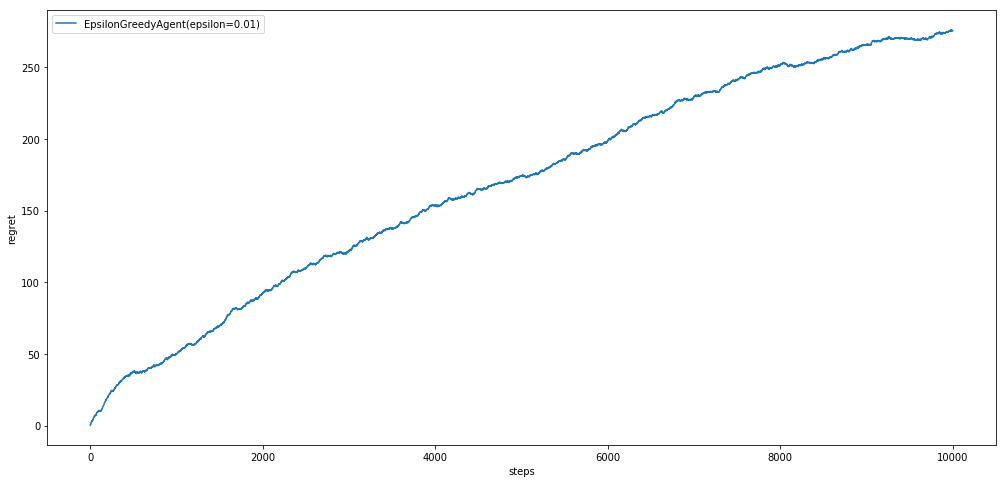

In [26]:
# Uncomment agents
agents = [
        EpsilonGreedyAgent()
    #     UCBAgent(),
    #     ThompsonSamplingAgent()
]

plot_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)

# Bonus 1.1. Gittins index (5 points).

Bernoulli bandit problem has an optimal solution - Gittins index algorithm. Implement finite horizon version of the algorithm and demonstrate it's performance with experiments. some articles:
- Wikipedia article - https://en.wikipedia.org/wiki/Gittins_index
- Different algorithms for index computation - http://www.ece.mcgill.ca/~amahaj1/projects/bandits/book/2013-bandit-computations.pdf (see "Bernoulli" section)
    

# HW 1.1. Nonstationary Bernoulli bandit

What if success probabilities change over time? Here is an example of such bandit:

In [97]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=0.01):
        """
        Idea from https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)

        self._gamma = gamma

        self._successes = None
        self._failures = None
        self._steps = 0

        self.reset()

    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.0
        self._failures = np.zeros(self.action_count) + 1.0
        self._steps = 0

    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)

    def _step(self, action, reward):
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probs = np.random.beta(self._successes, self._failures)

And a picture how it's reward probabilities change over time

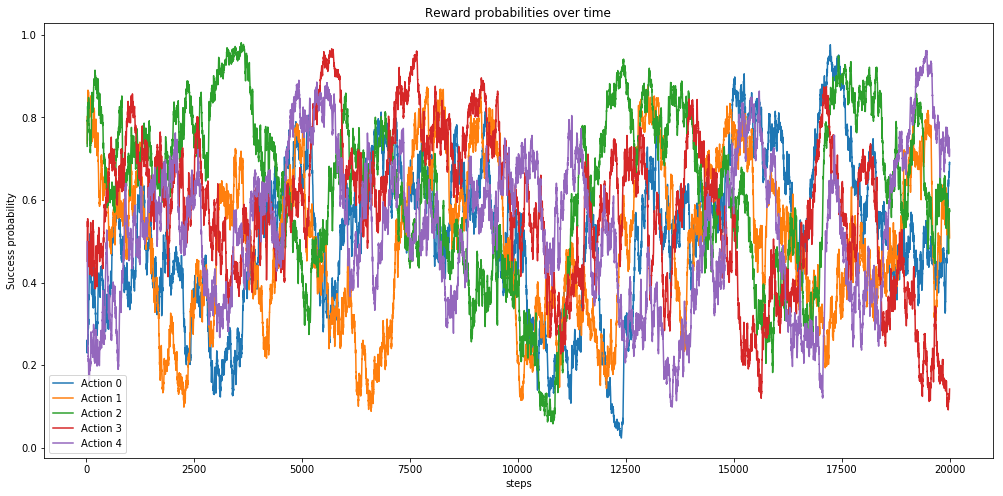

In [98]:
drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(17, 8))
plt.plot(pandas.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("steps")
plt.ylabel("Success probability")
plt.title("Reward probabilities over time")
plt.legend(["Action {}".format(i) for i in range(drifting_env.action_count)])
plt.show()

Your task is to invent an agent that will have better regret than stationary agents from above.

In [11]:
# YOUR AGENT HERE SECTION

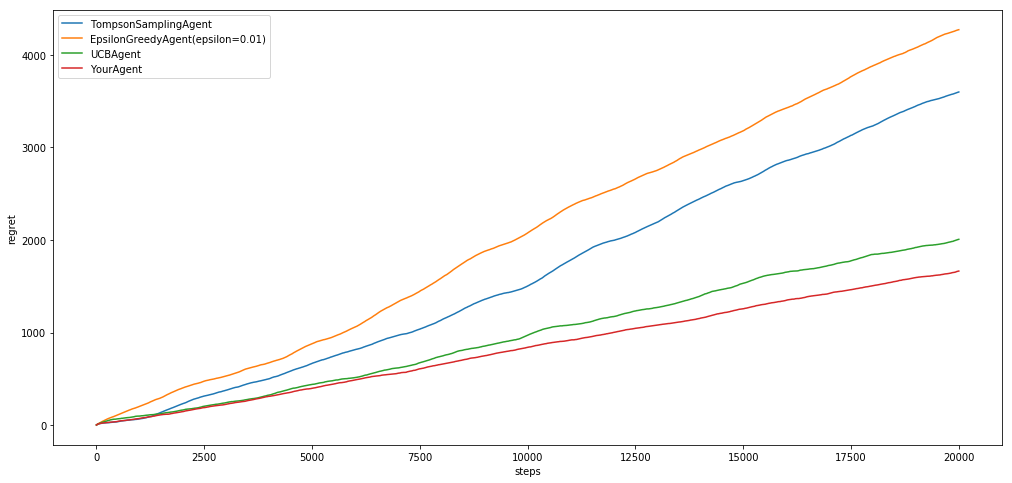

In [50]:
drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
    YourAgent()
]

plot_regret(DriftingBandit(), drifting_agents, n_steps=20000, n_trials=10)

## Part 2. Contextual bandit

Now we will solve much more complex problem - reward will depend on bandit's state.

**Real-word analogy:**

> Contextual advertising. We have a lot of banners and a lot of different users. Users can have different features: age, gender, search requests. We want to show banner with highest click probability.

If we want use strategies from above, we need some how store reward distributions conditioned both on actions and bandit's state. 
One way to do this - use bayesian neural networks. Instead of giving pointwise estimates of target, they maintain probability distributions

<img src="bnn.png">
Picture from https://arxiv.org/pdf/1505.05424.pdf


More material:
  * A post on the matter - [url](http://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/)
  * Theano+PyMC3 for more serious stuff - [url](http://pymc-devs.github.io/pymc3/notebooks/bayesian_neural_network_advi.html)
  * Same stuff in tensorflow - [url](http://edwardlib.org/tutorials/bayesian-neural-network)
  
Let's load our dataset:

In [2]:
all_states = np.load("all_states.npy")
action_rewards = np.load("action_rewards.npy")

state_size = all_states.shape[1]
n_actions = action_rewards.shape[1]

print("State size: %i, actions: %i" % (state_size, n_actions))

State size: 60, actions: 10


In [14]:
import theano
import theano.tensor as T
import lasagne
from lasagne import init
from lasagne.layers import *
import bayes

as_bayesian = bayes.bbpwrap(bayes.NormalApproximation(std=0.1))
BayesDenseLayer = as_bayesian(DenseLayer)

## 2.1 Bulding a BNN agent

Let's implement epsilon-greedy BNN agent

In [15]:
class BNNAgent:
    """a bandit with bayesian neural net"""

    def __init__(self, state_size, n_actions):
        input_states = T.matrix("states")
        target_actions = T.ivector("actions taken")
        target_rewards = T.vector("rewards")

        self.total_samples_seen = theano.shared(
            np.int32(0), "number of training samples seen so far")
        batch_size = target_actions.shape[0]  # por que?

        # Network
        inp = InputLayer((None, state_size), name='input')
        # YOUR NETWORK HERE
        out = <Your network >

        # Prediction
        prediction_all_actions = get_output(out, inputs=input_states)
        self.predict_sample_rewards = theano.function(
            [input_states], prediction_all_actions)

        # Training

        # select prediction for target action
        prediction_target_actions = prediction_all_actions[T.arange(
            batch_size), target_actions]

        # loss = negative log-likelihood (mse) + KL
        negative_llh = T.sum((prediction_target_actions - target_rewards)**2)

        kl = bayes.get_var_cost(out) / (self.total_samples_seen+batch_size)

        loss = (negative_llh + kl)/batch_size

        self.weights = get_all_params(out, trainable=True)
        self.out = out

        # gradient descent
        updates = lasagne.updates.adam(loss, self.weights)
        # update counts
        updates[self.total_samples_seen] = self.total_samples_seen + \
            batch_size.astype('int32')

        self.train_step = theano.function([input_states, target_actions, target_rewards],
                                          [negative_llh, kl],
                                          updates=updates,
                                          allow_input_downcast=True)

    def sample_prediction(self, states, n_samples=1):
        """Samples n_samples predictions for rewards,

        :returns: tensor [n_samples, state_i, action_i]
        """
        assert states.ndim == 2, "states must be 2-dimensional"

        return np.stack([self.predict_sample_rewards(states) for _ in range(n_samples)])

    epsilon = 0.25

    def get_action(self, states):
        """
        Picks action by 
        - with p=1-epsilon, taking argmax of average rewards
        - with p=epsilon, taking random action
        This is exactly e-greedy policy.
        """

        reward_samples = self.sample_prediction(states, n_samples=100)
        # ^-- samples for rewards, shape = [n_samples,n_states,n_actions]

        best_actions = reward_samples.mean(axis=0).argmax(axis=-1)
        # ^-- we take mean over samples to compute expectation, then pick best action with argmax

        # YOUR CODE HERE
        chosen_actions = <-- implement epsilon-greedy strategy - ->

        return chosen_actions

    def train(self, states, actions, rewards, n_iters=10):
        """
        trains to predict rewards for chosen actions in given states
        """
        loss_sum = kl_sum = 0
        for _ in range(n_iters):
            loss, kl = self.train_step(states, actions, rewards)
            loss_sum += loss
            kl_sum += kl

        return loss_sum / n_iters, kl_sum / n_iters

    @property
    def name(self):
        return self.__class__.__name__

## 2.2 Training the agent

In [16]:
N_ITERS = 100

In [17]:
def get_new_samples(states, action_rewards, batch_size=10):
    """samples random minibatch, emulating new users"""
    batch_ix = np.random.randint(0, len(states), batch_size)
    return states[batch_ix], action_rewards[batch_ix]

In [100]:
from IPython.display import clear_output

from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

def train_contextual_agent(agent, batch_size=10, n_iters=100):
    rewards_history = []

    for i in range(n_iters):
        b_states, b_action_rewards = get_new_samples(
            all_states, action_rewards, batch_size)
        b_actions = agent.get_action(b_states)
        b_rewards = b_action_rewards[
            np.arange(batch_size), b_actions
        ]

        mse, kl = agent.train(b_states, b_actions, b_rewards, n_iters=100)

        rewards_history.append(b_rewards.mean())

        if i % 10 == 0:
            clear_output(True)
            print("iteration #%i\tmean reward=%.3f\tmse=%.3f\tkl=%.3f" %
                  (i, np.mean(rewards_history[-10:]), mse, kl))
            plt.plot(rewards_history)
            plt.plot(moving_average(np.array(rewards_history), alpha=0.1))
            plt.title("Reward per epesode")
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.show()

            samples = agent.sample_prediction(
                b_states[:1], n_samples=100).T[:, 0, :]
            for i in range(len(samples)):
                plt.hist(samples[i], alpha=0.25, label=str(i))
                plt.legend(loc='best')
            print('Q(s,a) std:', ';'.join(
                list(map('{:.3f}'.format, np.std(samples, axis=1)))))
            print('correct', b_action_rewards[0].argmax())
            plt.title("p(Q(s, a))")
            plt.show()

    return moving_average(np.array(rewards_history), alpha=0.1)

iteration #90	mean reward=0.560	mse=0.457	kl=0.044


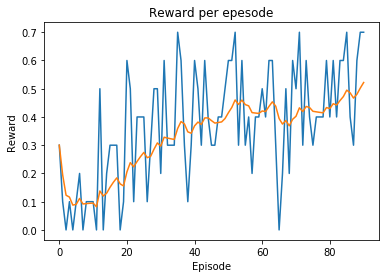

Q(s,a) std: 0.178;0.011;0.000;0.000;0.195;0.000;0.000;0.124;0.023;0.000
correct 4


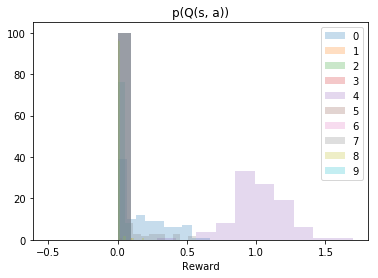

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


In [101]:
bnn_agent = BNNAgent(state_size=state_size, n_actions=n_actions)
greedy_agent_rewards = train_contextual_agent(
    bnn_agent, batch_size=10, n_iters=N_ITERS)

## HW 2.1 Better exploration

Use strategies from first part to gain more reward in contextual setting

In [20]:
class ThompsonBNNAgent(BNNAgent):
    def get_action(self, states):
        """
        picks action based by taking _one_ sample from BNN and taking action with highest sampled reward (yes, that simple)
        This is exactly thompson sampling.
        """

        # YOUR CODE HERE

iteration #90	mean reward=0.360	mse=0.590	kl=0.038


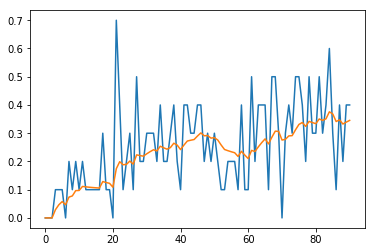

Q(s,a) std: 0.000;0.028;0.277;0.000;0.044;0.059;0.063;0.093;0.000;0.018
correct 2


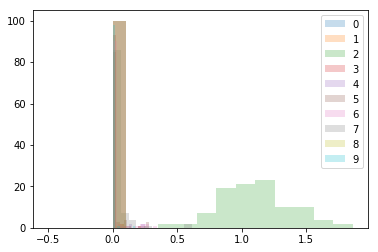

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


In [21]:
thompson_agent_rewards = train_contextual_agent(ThompsonBNNAgent(state_size=state_size, n_actions=n_actions),
                                               batch_size=10, n_iters=N_ITERS)

In [22]:
class BayesUCBBNNAgent(BNNAgent):
    q = 90

    def get_action(self, states):
        """
        Compute q-th percentile of rewards P(r|s,a) for all actions
        Take actions that have highest percentiles.

        This implements bayesian UCB strategy
        """

        # YOUR CODE HERE

iteration #90	mean reward=0.630	mse=0.354	kl=0.047


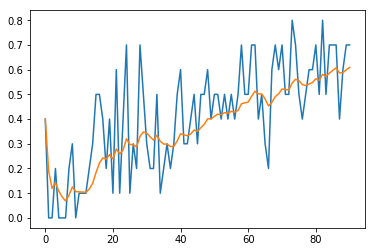

Q(s,a) std: 0.067;0.027;0.093;0.069;0.014;0.148;0.173;0.026;0.043;0.101
correct 5


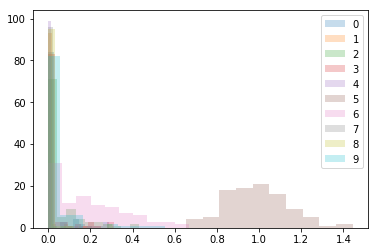

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


In [23]:
ucb_agent_rewards = train_contextual_agent(BayesUCBBNNAgent(state_size=state_size, n_actions=n_actions),
                                           batch_size=10, n_iters=N_ITERS)

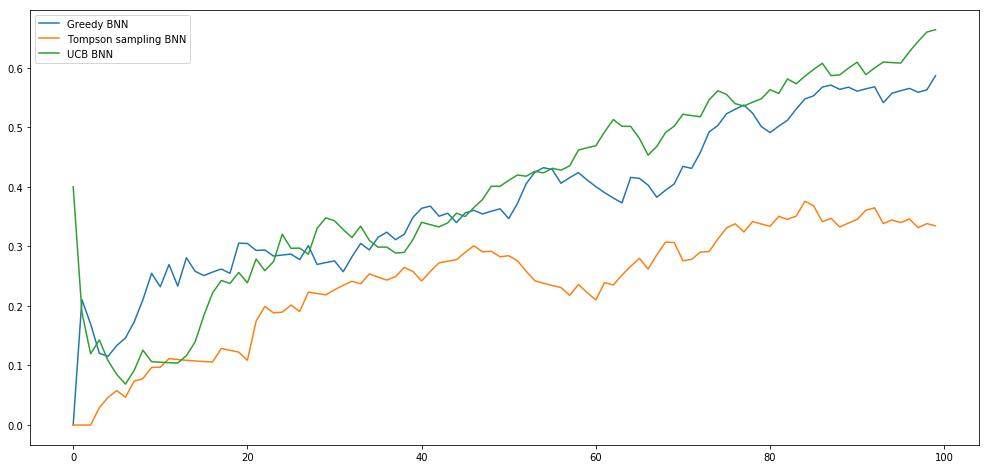

In [24]:
plt.figure(figsize=(17, 8))

plt.plot(greedy_agent_rewards)
plt.plot(thompson_agent_rewards)
plt.plot(ucb_agent_rewards)

plt.legend([
    "Greedy BNN",
    "Thompson sampling BNN",
    "UCB BNN"
])

plt.show()

## Part 3. Exploration in MDP

The following problem, called "river swim", illustrates importance of exploration in context of mdp's.

<img src="river_swim.png">

Picture from https://arxiv.org/abs/1306.0940

Rewards and transition probabilities are unknown to an agent. Optimal policy is to swim against current, while easiest way to gain reward is to go left.

In [25]:
class RiverSwimEnv:
    LEFT_REWARD = 5.0 / 1000
    RIGHT_REWARD = 1.0

    def __init__(self, intermediate_states_count=4, max_steps=16):
        self._max_steps = max_steps
        self._current_state = None
        self._steps = None
        self._interm_states = intermediate_states_count
        self.reset()

    def reset(self):
        self._steps = 0
        self._current_state = 1
        return self._current_state, 0.0, False

    @property
    def n_actions(self):
        return 2

    @property
    def n_states(self):
        return 2 + self._interm_states

    def _get_transition_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0, 1.0, 0]
            else:
                return [1.0, 0, 0]

        elif action == 1:
            if self._current_state == 0:
                return [0, .4, .6]
            if self._current_state == self.n_states - 1:
                return [.4, .6, 0]
            else:
                return [.05, .6, .35]
        else:
            raise RuntumeError(
                "Unknown action {}. Max action is {}".format(action, self.n_actions))

    def step(self, action):
        """
        :param action:
        :type action: int
        :return: observation, reward, is_done
        :rtype: (int, float, bool)
        """
        reward = 0.0

        if self._steps >= self._max_steps:
            return self._current_state, reward, True

        transition = np.random.choice(
            range(3), p=self._get_transition_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.LEFT_REWARD
        elif self._current_state == self.n_states - 1:
            reward = self.RIGHT_REWARD

        self._steps += 1
        return self._current_state, reward, False

Let's implement q-learning agent with epsilon-greedy exploration strategy and see how it performs.

In [26]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=0.2, gamma=0.95, epsilon=0.1):
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n_states, n_actions))
        self._lr = lr

    def get_action(self, state):
        if np.random.random() < self._epsilon:
            return np.random.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])

    def get_q_matrix(self):
        """ Used for policy visualization
        """

        return self._q_matrix

    def start_episode(self):
        """ Used in PSRL agent
        """
        pass

    def update(self, state, action, reward, next_state):
        # YOUR CODE HERE
        # Finish implementation of q-learnig agent

In [27]:
def train_mdp_agent(agent, env, n_episodes):
    episode_rewards = []

    for ep in range(n_episodes):
        state, ep_reward, is_done = env.reset()
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)

            next_state, reward, is_done = env.step(action)
            agent.update(state, action, reward, next_state)

            state = next_state
            ep_reward += reward

        episode_rewards.append(ep_reward)
    return episode_rewards

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


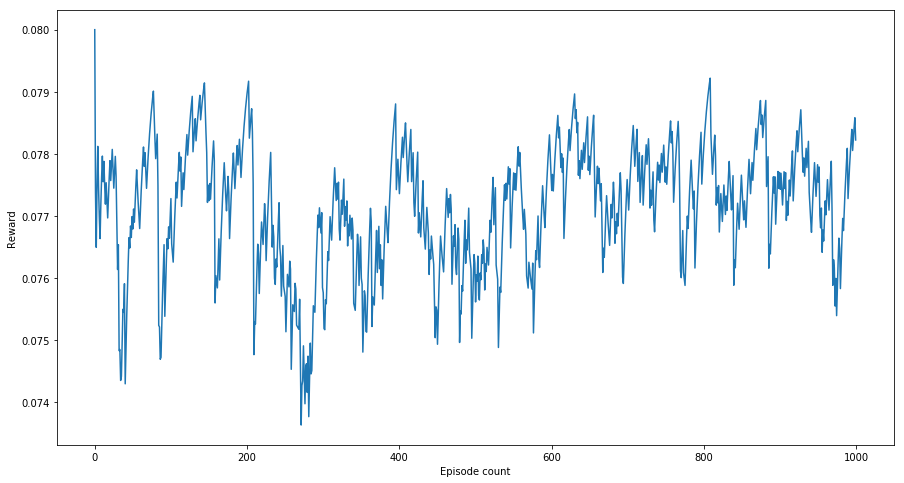

In [102]:
env = RiverSwimEnv()
agent = QLearningAgent(env.n_states, env.n_actions)
rews = train_mdp_agent(agent, env, 1000)
plt.figure(figsize=(15, 8))

plt.plot(moving_average(np.array(rews), alpha=.1))
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

Let's visualize our policy:

In [103]:
def plot_policy(agent):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.matshow(agent.get_q_matrix().T)
    ax.set_yticklabels(['', 'left', 'right'])
    plt.xlabel("State")
    plt.ylabel("Action")
    plt.title("Values of state-action pairs")
    plt.show()

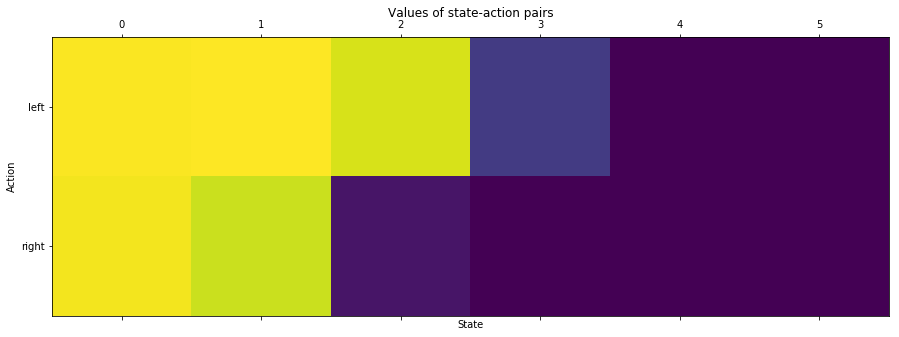

In [104]:
plot_policy(agent)

As your see, agent uses suboptimal policy of going left and does not explore the right state.

## Bonus 3.1 Posterior sampling RL (3 points)

Now we will implement Thompson Sampling for MDP!

General algorithm:

>**for** episode $k = 1,2,...$ **do**
>> sample $M_k \sim f(\bullet\ |\ H_k)$

>> compute policy $\mu_k$ for $M_k$

>> **for** time $t = 1, 2,...$ **do**

>>> take action  $a_t$ from $\mu_k$ 

>>> observe $r_t$ and $s_{t+1}$
>>> update $H_k$

>> **end for**

>**end for**

In our case we will model $M_k$ with two matricies: transition and reward. Transition matrix is sampled from dirichlet distribution. Reward matrix is sampled from normal-gamma distribution.

Distributions are updated with bayes rule - see continious distribution section at https://en.wikipedia.org/wiki/Conjugate_prior

Article on PSRL - https://arxiv.org/abs/1306.0940

In [105]:
def sample_normal_gamma(mu, lmbd, alpha, beta):
    """ https://en.wikipedia.org/wiki/Normal-gamma_distribution
    """
    tau = np.random.gamma(alpha, beta)
    mu = np.random.normal(mu, 1.0 / np.sqrt(lmbd * tau))
    return mu, tau


class PsrlAgent:
    def __init__(self, n_states, n_actions, horizon=10):
        self._n_states = n_states
        self._n_actions = n_actions
        self._horizon = horizon

        # params for transition sampling - Dirichlet distribution
        self._transition_counts = np.zeros(
            (n_states, n_states, n_actions)) + 1.0

        # params for reward sampling - Normal-gamma distribution
        self._mu_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._state_action_counts = np.zeros(
            (n_states, n_actions)) + 1.0  # lambda

        self._alpha_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._beta_matrix = np.zeros((n_states, n_actions)) + 1.0

    def _value_iteration(self, transitions, rewards):
        # YOU CODE HERE
        state_values = < Find action values with value iteration >
        return state_values

    def start_episode(self):
        # sample new  mdp
        self._sampled_transitions = np.apply_along_axis(
            np.random.dirichlet, 1, self._transition_counts)

        sampled_reward_mus, sampled_reward_stds = sample_normal_gamma(
            self._mu_matrix,
            self._state_action_counts,
            self._alpha_matrix,
            self._beta_matrix
        )

        self._sampled_rewards = sampled_reward_mus
        self._current_value_function = self._value_iteration(
            self._sampled_transitions, self._sampled_rewards)

    def get_action(self, state):
        return np.argmax(self._sampled_rewards[state] +
                         self._current_value_function.dot(self._sampled_transitions[state]))

    def update(self, state, action, reward, next_state):
        # YOUR CODE HERE
        # update rules - https://en.wikipedia.org/wiki/Conjugate_prior

    def get_q_matrix(self):
        return self._sampled_rewards + self._current_value_function.dot(self._sampled_transitions)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  import sys


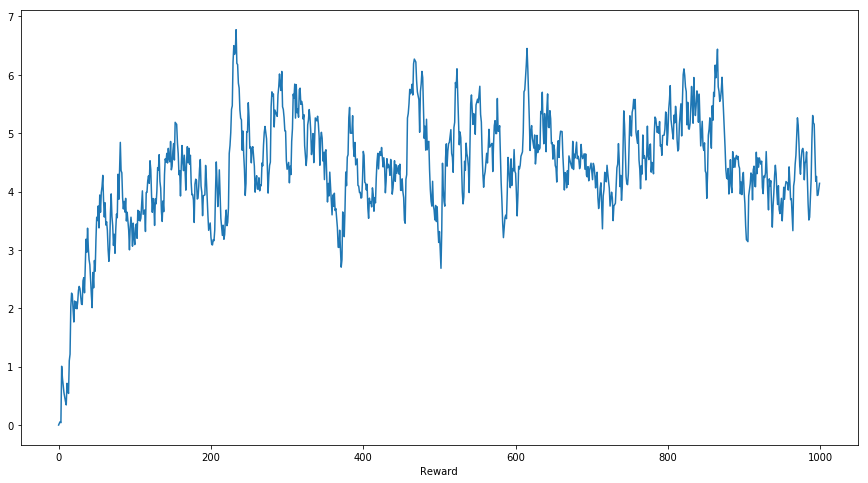

In [71]:
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

horizon = 20
env = RiverSwimEnv(max_steps=horizon)
agent = PsrlAgent(env.n_states, env.n_actions, horizon=horizon)
rews = train_mdp_agent(agent, env, 1000)

plt.figure(figsize=(15, 8))
plt.plot(moving_average(np.array(rews), alpha=0.1))

plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

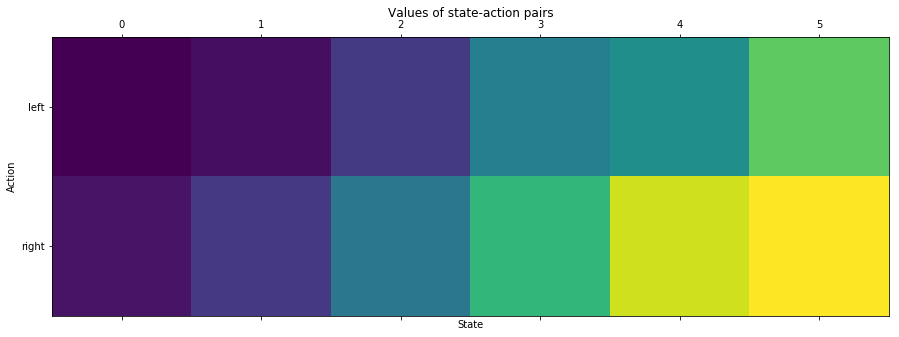

In [72]:
plot_policy(agent)

## Bonus 3.2 Bootstrapped DQN (10 points)

Implement Bootstrapped DQN algorithm and compare it's performance with ordinary DQN on BeamRider Atari game. Links:
- https://arxiv.org/abs/1602.04621